In [4]:
import sys
sys.path.append('..')
from cathedral_rl import cathedral_v0 
from cathedral_rl.game.board import Board 
 
import numpy as np
import matplotlib.pyplot as plt

import torch

from evaluate import evaluate_dqn

from train import train_dqn
from utils import select_action_dqn
from model import DQN



### Training

#### Hyperparameters

In [ ]:
board_size = 8

num_episodes = 12
buffer_capacity = 1000

treshold_penalize_illegal = 0
treshold_play_vs_random = 0

batch_size = 64
gamma = 0.95
learning_rate = 1e-3

prioritized_replay_buffer = True

parameters_updates = 10   
target_update_freq = 30  

epsilon_start = 1
epsilon_final = 0.1
epsilon_decay = 500
temperature_start = 1
temperature_final = 0.1
temperature_decay = 500

method = "boltzmann" # "eps_greedy" or "boltzmann"
model = "DQN" # "DQN" or "ResNet" or "DCNNet"

per_move_rewards=True
final_reward_score_difference=False

name = f'{per_move_rewards}_{final_reward_score_difference}_model_{model}_episodes{num_episodes}_buffer{buffer_capacity}_prioritized{prioritized_replay_buffer}_batch_size{batch_size}_gamma{gamma}_target_update{target_update_freq}_treshold_penalize{treshold_penalize_illegal}_{method}'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')



device : cuda


#### Functions

In [ ]:
train_dqn(name=name, 
        board_size=board_size, 
        num_episodes=num_episodes, 
        buffer_capacity=buffer_capacity, 
        treshold_penalize_illegal=treshold_penalize_illegal, 
        treshold_play_vs_random= treshold_play_vs_random,
        batch_size=batch_size,
        gamma=gamma, 
        learning_rate=learning_rate, 
        prioritized_replay_buffer=prioritized_replay_buffer, 
        parameters_updates=parameters_updates, 
        target_update_freq=target_update_freq, 
        epsilon_start=epsilon_start, 
        epsilon_final=epsilon_final, 
        epsilon_decay=epsilon_decay, 
        temperature_start=temperature_start, 
        temperature_final=temperature_final, 
        temperature_decay=temperature_decay, 
        method=method, 
        model=model, 
        per_move_rewards=per_move_rewards, 
        final_reward_score_difference=final_reward_score_difference, 
        device=device)
    

Model name : True_False_model_DQN_episodes12_buffer1000_prioritizedTrue_batch_size64_gamma0.95_target_update30_treshold_penalize0_boltzmann


n_actions : 1753
STOP penalizing illegal actions
Episode 5/12 - Reward total: -17.00 - Loss: 2.1729 - Winner: player_1- Temperature: 0.99
Episode 6/12 - Reward total: -34.00 - Loss: 0.1833 - Winner: player_0- Temperature: 0.99
Episode 7/12 - Reward total: -8.00 - Loss: 0.1628 - Winner: player_1- Temperature: 0.99
Episode 8/12 - Reward total: -29.00 - Loss: 0.3315 - Winner: player_1- Temperature: 0.99
Episode 9/12 - Reward total: -37.00 - Loss: 0.1132 - Winner: draw- Temperature: 0.99
Episode 10/12 - Reward total: -14.00 - Loss: 0.0532 - Winner: player_1- Temperature: 0.98
Episode 11/12 - Reward total: -44.00 - Loss: 0.1092 - Winner: player_1- Temperature: 0.98
Episode 12/12 - Reward total: -3.00 - Loss: 0.1271 - Winner: player_1- Temperature: 0.98
Winrate : 0.25


In [7]:
torch.serialization.add_safe_globals(["numpy._core.multiarray.scalar"])

data = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

# Extract lists for plotting
list_reward          = data['list_reward']
list_epsilon         = data['list_epsilon']
list_temperature     = data['list_temperature']
list_loss            = data['list_loss']
list_steps           = data['list_steps']
list_winner          = data['list_winner']
list_episode_ended   = data['list_episode_ended']
list_legal_actions   = data['list_legal_actions']

window_size = 2  # window size for smoothing
episodes = np.arange(1, len(list_reward) + 1)


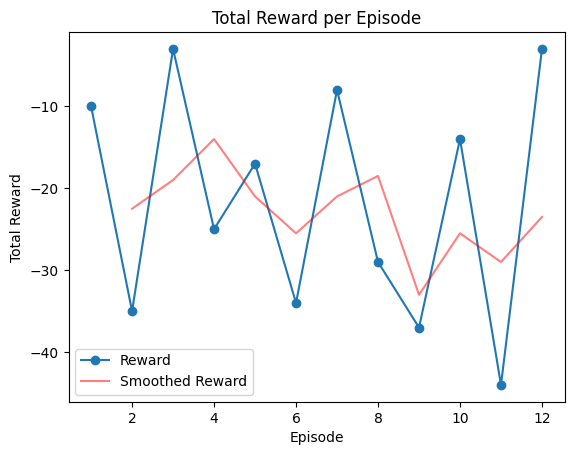

In [8]:
# Compute the smoothed values
smoothed_rewards = np.convolve(list_reward, np.ones(window_size)/window_size, mode='valid')

# 1. Total Reward per Episode with smoothed average
plt.plot(episodes, list_reward, marker='o', linestyle='-', label="Reward")
plt.plot(episodes[window_size-1:], smoothed_rewards, alpha=0.5, linestyle='-', color='red', label="Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

plt.savefig(f"results_DQN/rewards_{name}.png", dpi=300)

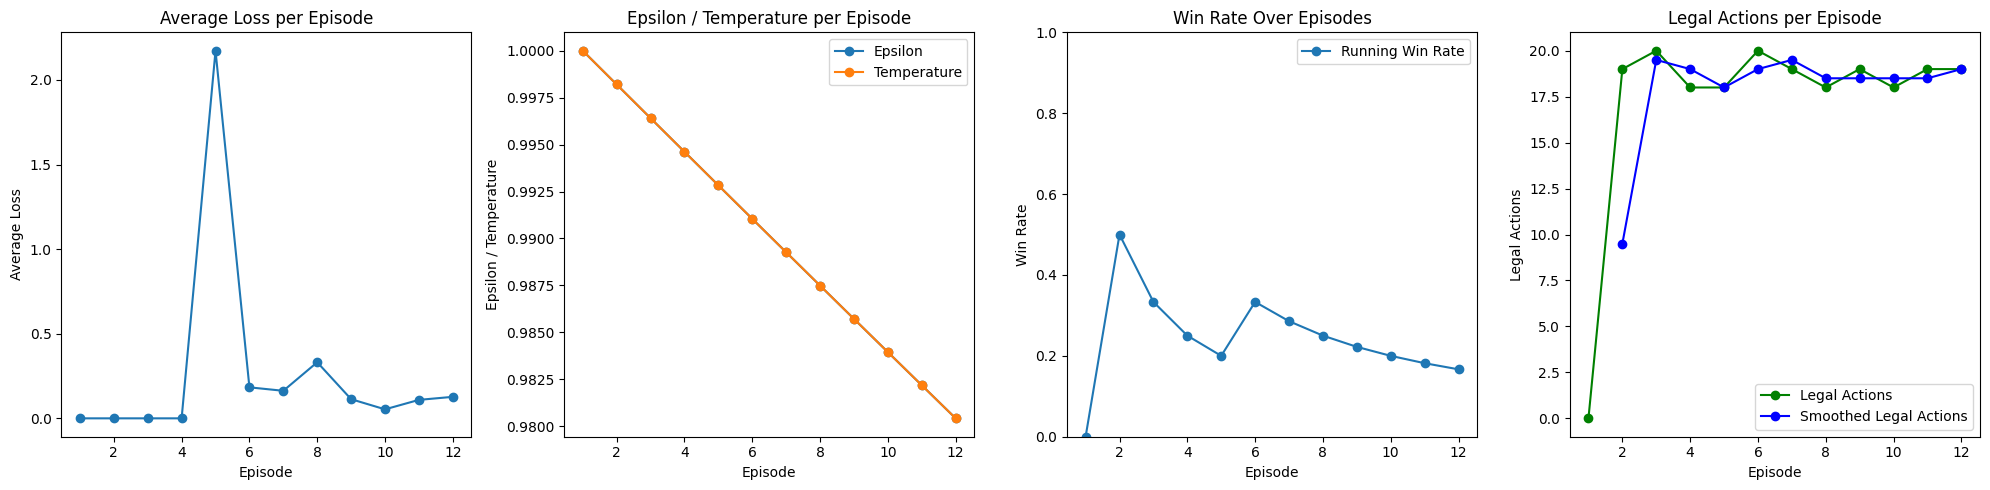

In [9]:
# Compute the smoothed values
smoothed_legal_actions = np.convolve(list_legal_actions, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(20, 5))  # Adjust height since all plots are on one row

# 1. Average Loss per Episode
plt.subplot(1, 4, 1)
plt.plot(episodes, list_loss, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Average Loss")
plt.title("Average Loss per Episode")

# 2. Epsilon / Temperature per Episode
plt.subplot(1, 4, 2)
if method == "eps_greedy":
    plt.plot(episodes, list_epsilon, marker='o', linestyle='-')
    plt.ylabel("Epsilon")
    plt.title("Epsilon per Episode")
elif method == "boltzmann":
    plt.plot(episodes, list_epsilon, marker='o', linestyle='-', label="Epsilon")
    plt.plot(episodes, list_temperature, marker='o', linestyle='-', label="Temperature")
    plt.ylabel("Epsilon / Temperature")
    plt.title("Epsilon / Temperature per Episode")
    plt.legend()
plt.xlabel("Episode")

# 3. Win Rate Over Episodes
plt.subplot(1, 4, 3)
won_list = [1 if w == 1 else 0 for w in list_winner]
cumulative_wins = np.cumsum(won_list)
win_rate = cumulative_wins / np.arange(1, len(won_list) + 1)
plt.plot(episodes, win_rate, marker='o', linestyle='-', label="Running Win Rate")
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.title("Win Rate Over Episodes")
plt.ylim([0, 1])
plt.legend()

# 4. Legal Actions per Episode
plt.subplot(1, 4, 4)
plt.plot(episodes, list_legal_actions, marker='o', linestyle='-', color='green', label="Legal Actions")
plt.plot(episodes[window_size-1:], smoothed_legal_actions, marker='o', linestyle='-', color='blue', label="Smoothed Legal Actions")
plt.xlabel("Episode")
plt.ylabel("Legal Actions")
plt.title("Legal Actions per Episode")
plt.legend()

plt.tight_layout()
plt.savefig(f"results_DQN/training_{name}.png", dpi=300)
plt.show()


### Evaluate

#### PLay One Episode (testing purposes / sanity check)

In [10]:
env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
env.reset()

controlled_agent='player_0'

n_actions = env.action_space('player_0').n
obs_shape = env.observe('player_0')["observation"].shape  

print(f'Model name: {name}')
checkpoint = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

policy_net = DQN(obs_shape, n_actions).to(device)
policy_net.load_state_dict(checkpoint['model_state_dict'])

env.reset()
total_reward = 0

while env.agents:
    current_agent = env.agent_selection
    observation = env.observe(current_agent)
    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    
    state = observation["observation"]
    action_mask = observation["action_mask"]
        
    first_action, action = select_action_dqn(policy_net, state, action_mask, legal_moves, device, method, 0, 0, training=False)
               
    env.step(action)
    
    
    print(f"Current agent: {current_agent} Action: {action}")
    print("== REWARD ==")
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print("== RENDER ==")
    env.render()
    print('\n')
print(f"Winnner: {env.winner}")


Model name: True_False_model_DQN_episodes12_buffer1000_prioritizedTrue_batch_size64_gamma0.95_target_update30_treshold_penalize0_boltzmann
Current agent: player_1 Action: 1688
== REWARD ==
rewards : {'player_1': 0, 'player_0': 0}
cumulative reward : {'player_1': 0, 'player_0': 0}
== RENDER ==
Board: 
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 3. 3. 3. 3. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Territory: 
 [[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  0. -1. -1. -1.]
 [-1. -1. -1.  0.  0.  0.  0. -1.]
 [-1. -1. -1. -1.  0. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


Current agent: player_0 Action: 240
== REWARD ==
rewards : {'player_1': 0, 'player_0': 0}
cumulative reward : {'player_1': 0, 'player_0': 0}
== RENDER ==
Board: 
 [[2. 2. 0. 0. 0. 0. 0

#### Evaluate with Metrics

In [11]:
# -1 : random opponent // -2 : self opponent
avg_reward = evaluate_dqn(name=name, opponents = [-1], board_size=board_size, device=device,  num_episodes_eval=20)

Opponent -1


  5%|▌         | 1/20 [00:00<00:08,  2.26it/s]

100%|██████████| 20/20 [00:08<00:00,  2.27it/s]

Opponent -1 : 20 episodes => Avg Reward : -8.4180 // Winrate : 0.2250


10000 episodes : 
Opponent -1 : 1000 episodes => Avg Reward : 3.0366 // Winrate : 0.9700
Opponent -2 : 1000 episodes => Avg Reward : 4.1122 // Winrate : 0.7250

4000 episodes eps: decay 500
Opponent -1 : 1000 episodes => Avg Reward : 2.7311 // Winrate : 0.9390
Opponent -2 : 1000 episodes => Avg Reward : 2.4739 // Winrate : 0.8610

4000 episodes boltzmann: decay 500
Opponent -1 : 1000 episodes => Avg Reward : 2.8511 // Winrate : 0.9630